In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

# 预训练 word2vec
继续实现跳元模型, 并且在 `PTB`数据集上使用负采样来预训练 `word2vec`

In [2]:
# 加载数据集
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

## 跳元模型
通过嵌入层和批量矩阵乘法来实现跳元模型

### 嵌入层
嵌入层把词元索引映射到特征向量, 权重为一个矩阵, 行数为词表大小, 列数为每一个标记的向量维度

In [4]:
# 词表大小 20, 维度 4
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}),',
      f'dtype = {embed.weight.dtype}')

Parameter embedding_weight (torch.Size([20, 4])), dtype = torch.float32


In [6]:
# 可以选择对应的数字对应的索引
x = torch.tensor([[1, 2, 3], [3, 4, 5]])
embed(x).shape, x.shape

(torch.Size([2, 3, 4]), torch.Size([2, 3]))

### 定义前向传播
前向传播中, 跳元语法模型的输入包括形状为 `(batch_size, 1)`的中心词索引 `center` 以及形状为 `(batch_size, max_len)` 的上下文词和噪声词索引 `context_and_negatives`; 这两个变量首先通过嵌入层从词元索引转换为向量, 然后通过批量矩阵相乘, 返回形状为 `(batch_size, 1, max_len)`, 输出中灭一个元素就是中心词向量和上下文向量或噪声词向量的点积 

In [8]:
# 跳元模型前向传播, 返回的就是 u_o^T v_c 的值, 进行 Softmax 操作之后就可以得到 P(w_o | w_c)
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    # center.shape -> (batch_size, 1)
    # contexts_and_negatives.shape -> (batch_size, maxlen)
    # v.shape -> (batch_size, 1, dim)
    # u.shape -> (batch_size, maxlen, dim)
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [10]:
# 测试 skip_gram
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## 训练
损失函数可以使用交叉熵损失
### 二元交叉熵损失
一般用于二分类问题, 给定一个一样本 $x$, 真实标签 $y \in \{0,1\}$, 二元交叉熵损失定义为:
$$
BCEWithLogitsLoss(z,y) = max(z, 0) - z*y + \log(1 + e^{-|z|})
$$
其中 $z$ 为预测值, $y$ 为标签值

In [26]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [27]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1) # 类似于一个 Dropout 操作

tensor([0.9352, 1.8462])

In [25]:
# 利用 sigmoid 函数计算
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### 初始化模型参数
定义两个嵌入层, 并且把词表中的所有单词分别作为中心词和上下文词使用, 词向量维度设置为 $100$

In [28]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab),
                 embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab),
                 embedding_dim=embed_size)
)

### 训练阶段代码

In [29]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.409, 185550.8 tokens/sec on cpu


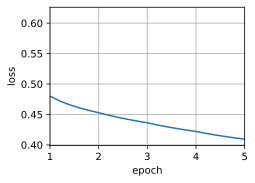

In [30]:
# 使用负采样来训练跳元模型
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## 应用词嵌入

In [32]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    # 获取到对应的词向量
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.693: intel
cosine sim=0.658: microprocessor
cosine sim=0.635: chips
